# Uniform Sampling Tests on Polygones

This repository deals with sampling methods from $(K-1)$ dimensional polytopes. 


1. imports:


In [90]:
import sys
sys.path.append('../')

import numpy as np
from numpy.random import dirichlet
from scipy.spatial import ConvexHull
import ternary
import matplotlib.pyplot as plt
import matplotlib
import torch

from composition_stats import ilr, ilr_inv

from mhar import walk

from ensemblecalibration.transformations.projections_2d import project_point2D, plane_to_coordinate3D, project_points2D, planes_to_coordinates3D

plt.rcParams['figure.dpi'] = 100
# plt.rcParams['figure.figsize'] = (4, 4)

### Initialize setting

### sample points from dirichlet distribution

sampling points form the Dirichlet distribution yields uniform samples over the (M-1) simplex. 

In particular, for M=3, and $\alpha_j=1$ for $j=1,2,3$, the density is given by

$f(x_1,x_2, x_3) = \frac{1}{B(1)} $ with $\sum_{i=1}^3 x_i=1$, $x_i \in [0, 1]$ for $i \in {1,2,3}$ and

$$ B(\alpha) = \frac{\prod_{i=1}^K \Gamma(\alpha_i)}{\gamma(\sum_{i=1}^K\alpha_i)}$$

 the multivariate beta function.

In [91]:
points = dirichlet([1]*3, size=10000) # alpha_i = 1 for i=1,2,3

points[points[:, 1] <= 0.5].shape

(7508, 3)

 ## plot  3-simplex with  uniformly drawn points

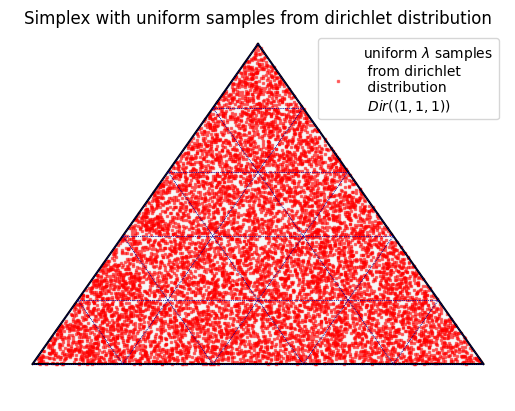

In [92]:
matplotlib.rcParams.update({'font.size': 10})

scale = 1

# ternary figure
fig, tax = ternary.figure(scale=scale)
tax.boundary(linewidth=1.5)

tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# Set ticks

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the detault, essentially
tax.scatter([tuple(points[i]) for i in range(len(points))], marker='s', color='red', s= 1, alpha=0.5, label='uniform $\lambda$ samples \n from dirichlet \n distribution \n $Dir((1,1,1))$')
# tax.scatter(predicts, marker='D', color='b')

tax.legend()

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

# title
tax.set_title('Simplex with uniform samples from dirichlet distribution')

plt.show()



### Polytope of 3 predictors in the 2-simplex

In [93]:
predicts = [(0.2, 0.2, 0.8), (0.8, 0.2, 0.2), (0.2,0.8,0.2)] # point predictions of three predictive models
# as array
predicts_array = np.stack([np.asarray(predicts[i]) for i in range(len(predicts))])

### Computation of the convex hull using Scipy

first step: project the points on the 2D plane (otherwise scipy throws an error)

In [94]:
predicts_2D = project_points2D(predicts)

now compute teh convex hull

In [95]:
# compute convex hull
hull = ConvexHull(predicts_2D)


### Sampling convex combinations of predictions: by uniform sampling from the simplex

In [96]:
# function for uniformly sampling weights from the dirichlet distribution
def sample_predictions_uniform_simplex(preds: np.ndarray, size: int = 1000):
    """function for sampling new convex combinations of the predictions using coefficients uniformly sampled
        from the (dim -1) simplex.

    Parameters
    ----------
    preds : np.ndarray of shape (n_predictions, 3) (must be three dimensional for visualizing)
        array of point predictions 
    size : int, optional
        number of samples, by default 1000

    Returns
    -------
    np.ndarray
        array of samples convex combinations
    """

    dim = len(preds) # defines shape of weights
    lambdas = dirichlet([1]*dim, size=size) # vectors of samples convex combinations of shape (size, dim)
    preds_new = lambdas @ preds 

    return preds_new


In [97]:

preds_samples = sample_predictions_uniform_simplex(predicts_array, size=10000)

### function for getting the pairs of vertices connecting the convex hull of a number of 3-dimensional points sampled from the 2-simplex:

Using a projection to the 2-dimensional plane and the respective backtransformation

In [98]:
def get_vertex_pairs_hull(points3D: np.ndarray):
    """returns an array of vertices for the given 3-dimensional points in the 2-simplex.
    Works by first projecting them int the 2-dimensional coordinate plane, calculating the vertices of the convex hull,
     and then back-transformin to 3-dimensions.

    Parameters
    ----------
    points3D : np.ndarray of shape (n_points, 3)
        initial points

    Returns
    -------
    np.ndarray of shape (n_vertices, 3)
        vertex points
    """

    proj_points = project_points2D(points3D=points3D) # projected on two-dimensional plane to compute ConvexHull
    hull = ConvexHull(proj_points)
    vertices2d = proj_points[hull.vertices]

    vertices = planes_to_coordinates3D(vertices2d) # back projection 

    return vertices


get_vertex_pairs_hull(predicts)

array([[ 2.00000000e-01,  2.00000000e-01,  6.00000000e-01],
       [ 8.00000000e-01,  2.00000000e-01, -5.55111512e-17],
       [ 2.00000000e-01,  8.00000000e-01, -1.11022302e-16]])

In [99]:
test_vec = np.array([[.2, .2, .6], [.4, .4, .2]])
out = ilr(predicts_array)
out

array([[-1.22584781e-16, -1.13190461e+00],
       [ 9.80258143e-01,  5.65952303e-01],
       [-9.80258143e-01,  5.65952303e-01]])

In [100]:
def get_vertex_pairs_hull_iso(points: np.ndarray):
    """returns an array of vertices for the given 3-dimensional points in the 2-simplex.
    Works by first projecting them int the 2-dimensional coordinate plane, calculating the vertices of the convex hull,
     and then back-transformin to 3-dimensions.

    Parameters
    ----------
    points3D : np.ndarray of shape (n_points, dim)
        initial points

    Returns
    -------
    np.ndarray of shape (n_vertices, 3)
        vertex points
    """

    proj_points = project_points2D(points3D=points3D) # projected on two-dimensional plane to compute ConvexHull
    hull = ConvexHull(proj_points)
    vertices2d = proj_points[hull.vertices]

    vertices = planes_to_coordinates3D(vertices2d) # back projection 

    return vertices

### plot samples in the convex hull of predictions

Text(0.5, 1.0, 'Convex Hull of predictors')

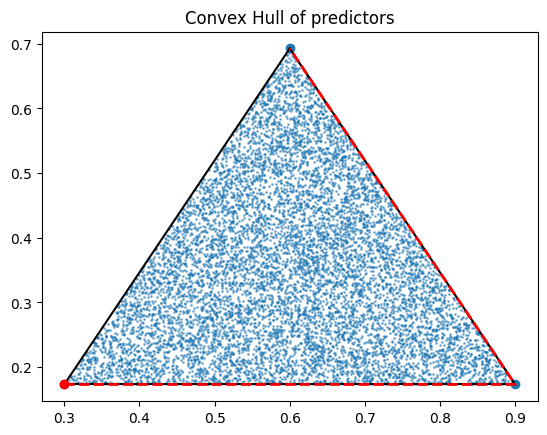

In [101]:
plt.plot(predicts_2D[:,0], predicts_2D[:, 1], 'o')
for simplex in hull.simplices:
    plt.plot(predicts_2D[simplex, 0], predicts_2D[simplex, 1], 'k-')
plt.plot(predicts_2D[hull.vertices, 0], predicts_2D[hull.vertices, 1], 'r--', lw=2)
plt.plot(predicts_2D[hull.vertices[0], 0], predicts_2D[hull.vertices[0], 1], 'ro')


proj_samples = project_points2D(preds_samples)
plt.scatter(proj_samples[:,0], proj_samples[:,1], alpha=0.5, s=1)

plt.title("Convex Hull of predictors")

polytope within the 2-simplex:

In [102]:
predicts = [(0.2, 0, 0.8),(0.2, 0.4, 0.4), (0.8, 0.2,0.2)] # point predictions of three predictive models
# as array
predicts_array = np.stack([np.asarray(predicts[i]) for i in range(len(predicts))])

preds_samples = sample_predictions_uniform_simplex(predicts_array, size=10000)

v_0 = np.array(list(predicts[0]))
predicts_array = np.vstack([predicts_array, v_0])
predicts_array

array([[0.2, 0. , 0.8],
       [0.2, 0.4, 0.4],
       [0.8, 0.2, 0.2],
       [0.2, 0. , 0.8]])

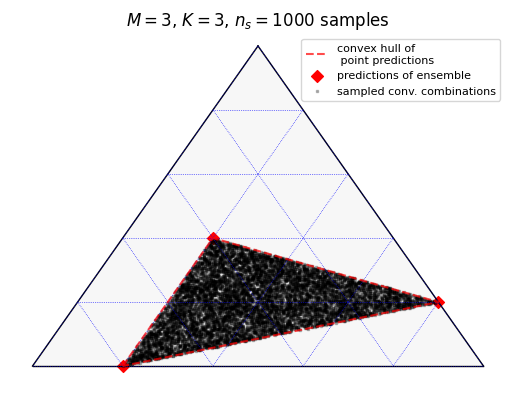

In [103]:
scale = 1

fig, tax = ternary.figure(scale=scale)
tax.boundary(linewidth=1.0)

# tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# scatter predictors
tax.plot(predicts_array, linestyle='--',color='red',alpha=0.7, label='convex hull of \n point predictions')
tax.scatter(predicts, color='red', marker='D', label='predictions of ensemble')
tax.scatter(preds_samples, marker='s', s=1.5, alpha=0.25, color='black', label='sampled conv. combinations')

# Remove default Matplotlib Axes
# tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.title('$M=3$, $K=3$, $n_s=1000$ samples')
plt.legend(fontsize=8)


### Test 2: $M=6$ predictors

#### 1. sampling of predictions by unifomrly sampling from the space of all convex combinations

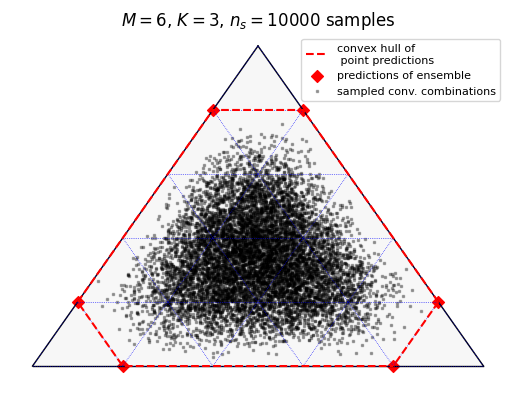

In [128]:
predicts = [(0.2, 0.8, 0.0), (0.8, .2, 0.0), (0.0, .8, .2), (0.0, .2, .8), (.8, 0, .2), (.2, 0, .8)]

# as array
preds_array = np.stack([np.asarray(predicts[i]) for i in range(len(predicts))])
# vertices of convex hull
preds_vertices = get_vertex_pairs_hull(preds_array)

preds_samples = sample_predictions_uniform_simplex(preds_array, size=10000)

# PLOT 
scale = 1

fig, tax = ternary.figure(scale=scale)
tax.boundary(linewidth=1.0)

# tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# scatter predictors
tax.plot(preds_vertices, color = 'red', linestyle='--', label='convex hull of \n point predictions')
tax.plot(preds_vertices[[0, len(preds_vertices) -1]], color='red', linestyle='--')
tax.scatter(predicts, color='red', marker='D', label='predictions of ensemble')
tax.scatter(preds_samples, marker='s', color='black', s=1.5, alpha=0.3, label='sampled conv. combinations')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.title('$M=6$, $K=3$, $n_s=10000$ samples')
plt.legend(fontsize=8)

#### 2. sampling by using an MCMC algorithm (matrix hit and run)

function which yields the inequality constraints from the polytope:

In [105]:
def get_polytope_equations(points3D: np.ndarray):
    """function exrtacting the hyperplane inequality constraints 
    given points in the 3-dim space from a 2-simplex

    Parameters
    ----------
    points3D : np.ndarray of shape (n_points, 3)
        points from a 2-simplex

    Returns
    -------
    tensors A of shape (n_facets, 2)
            b of shape (n_facets, 1)

        defining the polytope P in a way s.t. 

            P = {x in R^2: Ax <= b}
    """

    proj_points = project_points2D(points3D=points3D) # project to 2 dimensions
    hull = ConvexHull(proj_points) # compute convex hull

    eqs = hull.equations # hyperplane equations of the facets of shape (n_facets, 3)

    A = eqs[:, :-1]
    b = - eqs[:, -1:]

    return A, b


In [106]:
A, b = get_polytope_equations(preds_array)

# need an inner point to start the random walk
x_0 = torch.from_numpy(project_point2D(np.array([1/3, 1/3, 1/3,]))).view(2, -1).type(torch.FloatTensor)
A = torch.from_numpy(A).type(torch.FloatTensor)
b = torch.from_numpy(b).type(torch.FloatTensor)

X = walk(z=10000,
ai=A,
bi=b,
ae = torch.empty(0),
be = torch.empty(0),
x_0=x_0,
T=1, 
device='cpu',
warm=0,
seed=None,
thinning=None
)

print(X)
print(X.shape)

n:  2   mi: 6   me: 0   z: 10000
Automatic Thinning factor:  8
tensor([[0.5581, 0.4034],
        [0.5623, 0.0228],
        [0.3687, 0.5890],
        ...,
        [0.5967, 0.5582],
        [0.5765, 0.4370],
        [0.4610, 0.3370]])
torch.Size([10000, 2])


### now project them back to 3 dimension


In [107]:
x_projected = planes_to_coordinates3D(X.numpy())
x_projected

array([[0.32516094, 0.46577843, 0.20906063],
       [0.54911195, 0.02631476, 0.42457329],
       [0.02865097, 0.68009162, 0.29125741],
       ...,
       [0.27444843, 0.64455336, 0.08099821],
       [0.3241923 , 0.50459609, 0.17121161],
       [0.26646956, 0.38915344, 0.344377  ]])

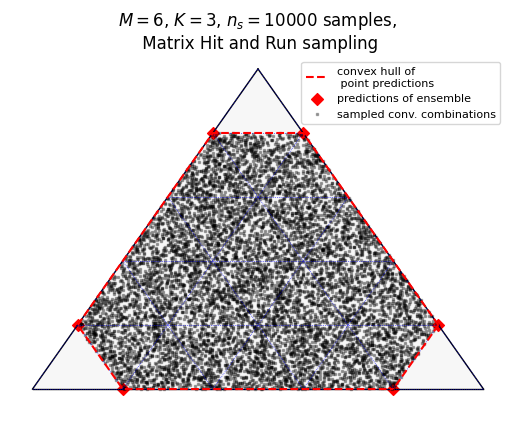

In [108]:
# PLOT 
scale = 1

fig, tax = ternary.figure(scale=scale)
tax.boundary(linewidth=1.0)

# tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# scatter predictors
tax.plot(preds_vertices, color = 'red', linestyle='--', label='convex hull of \n point predictions')
tax.plot(preds_vertices[[0, len(preds_vertices) -1]], color='red', linestyle='--')
#tax.plot(preds_vertices[[0, len(preds_vertices) -1]], color='r', linstyle='--')
tax.scatter(predicts, marker='D', color='red', label='predictions of ensemble')
tax.scatter(x_projected, marker='s', s=1.5, alpha=0.3, color='black', label='sampled conv. combinations')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.title('$M=6$, $K=3$, $n_s=10000$ samples, \n Matrix Hit and Run sampling', )
plt.legend(fontsize=8)

### Test 3: predictions point within the polytope

In [109]:
predicts = [(0.2, 0.8, 0.0), (0.8, .2, 0.0), (0.0, .8, .2), (0.0, .2, .8), (.8, 0, .2), (.2, 0, .8)] # point predictions of three predictive models
# append middle point
predicts.append((1/3 +1/10, 1/3, 1/3 - 1/10))
predicts.append((1/3, 1/3 -1/10, 1/3 +1/10))
predicts.append((1/3 -1/10, 1/3 +1/10, 1/3))
predicts_array = np.stack([np.asarray(predicts[i]) for i in range(len(predicts))])


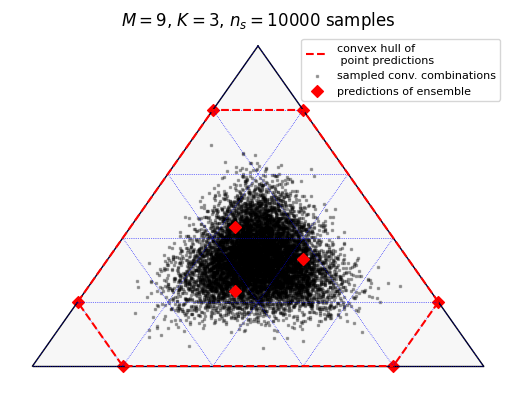

In [110]:
preds_samples = sample_predictions_uniform_simplex(predicts_array, size=10000)

preds_vertices = get_vertex_pairs_hull(preds_array)


# PLOT 
scale = 1

fig, tax = ternary.figure(scale=scale)
tax.boundary(linewidth=1.0)

# tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# scatter predictors
tax.plot(preds_vertices, color = 'red', linestyle='--', label='convex hull of \n point predictions')
tax.plot(preds_vertices[[0, len(preds_vertices) -1]], color='red', linestyle='--')
tax.scatter(preds_samples, marker='s', color='black', s=1.5, alpha=0.3, label='sampled conv. combinations')
tax.scatter(predicts, color='red', marker='D', label='predictions of ensemble')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.title('$M=9$, $K=3$, $n_s=10000$ samples')
plt.legend(fontsize=8)

now with MCMC sampling

In [111]:
A, b = get_polytope_equations(predicts_array)

# need an inner point to start the random walk
x_0 = torch.from_numpy(project_point2D(np.array([1/3, 1/3, 1/3,]))).view(2, -1).type(torch.FloatTensor)
A = torch.from_numpy(A).type(torch.FloatTensor)
b = torch.from_numpy(b).type(torch.FloatTensor)

X = walk(z=10000,
ai=A,
bi=b,
ae = torch.empty(0),
be = torch.empty(0),
x_0=x_0,
T=1, 
device='cpu',
warm=0,
seed=None,
thinning=None
)

x_projected = planes_to_coordinates3D(X.numpy())


n:  2   mi: 6   me: 0   z: 10000
Automatic Thinning factor:  8


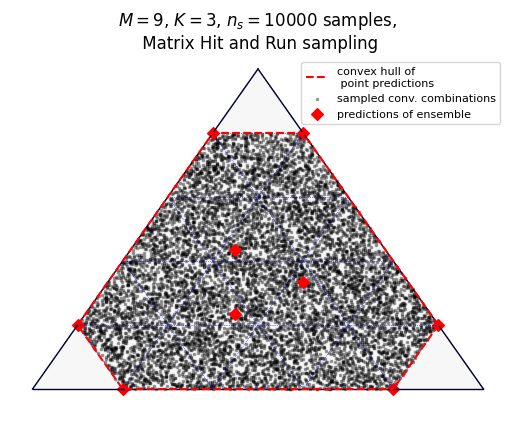

In [112]:
# PLOT 
scale = 1

fig, tax = ternary.figure(scale=scale)
tax.boundary(linewidth=1.0)

# tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# scatter predictors
tax.plot(preds_vertices, color = 'red', linestyle='--', label='convex hull of \n point predictions')
tax.plot(preds_vertices[[0, len(preds_vertices) -1]], color='red', linestyle='--')
#tax.plot(preds_vertices[[0, len(preds_vertices) -1]], color='r', linstyle='--')
tax.scatter(x_projected, marker='s', s=1.5, alpha=0.3, color='black', label='sampled conv. combinations')
tax.scatter(predicts, marker='D', color='red', label='predictions of ensemble')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.title('$M=9$, $K=3$, $n_s=10000$ samples, \n Matrix Hit and Run sampling', )
plt.legend(fontsize=8)

### Using the Delanay Triangulization

In [113]:
from scipy.spatial import Delaunay

In [114]:
# points
predicts = [(0.2, 0.8, 0.0), (0.8, .2, 0.0), (0.0, .8, .2), (0.0, .2, .8), (.8, 0, .2), (.2, 0, .8)] # point predictions of three predictive models

predicts_array = np.stack([np.asarray(predicts[i]) for i in range(len(predicts))])


In [115]:
# transform to 2d
predicts_2d = project_points2D(predicts_array)
predicts_array

array([[0.2, 0.8, 0. ],
       [0.8, 0.2, 0. ],
       [0. , 0.8, 0.2],
       [0. , 0.2, 0.8],
       [0.8, 0. , 0.2],
       [0.2, 0. , 0.8]])

In [116]:
delaunay = Delaunay(predicts_2d)
delaunay.simplices

array([[0, 5, 1],
       [5, 2, 3],
       [5, 4, 1],
       [2, 5, 0]], dtype=int32)

[]

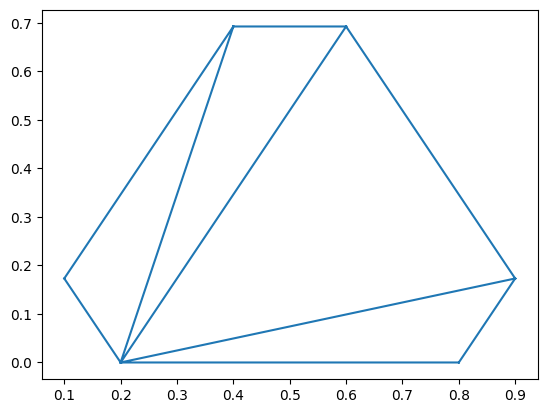

In [117]:
plt.triplot(predicts_2d[:, 0], predicts_2d[:,1], delaunay.simplices)
plt.plot()

In [118]:
predicts_2d[delaunay.simplices].shape

(4, 3, 2)

In [119]:
def sample_from_delaunay_triangles(predict_points: np.ndarray, points_per_tri: int = 4000):

    # project to 2 D
    proj_points = project_points2D(predict_points)

    # delaunay triangulization
    tri = Delaunay(proj_points)

    simplices = proj_points[tri.simplices]
    
    simplices_3d = []
    list_samples = []
    for j in range(simplices.shape[0]):
        points_3d = planes_to_coordinates3D(simplices[j])
        samples = sample_predictions_uniform_simplex(points_3d, size=points_per_tri)
        simplex_3d = planes_to_coordinates3D(simplices[j])
        list_samples.append(samples)
        simplices_3d.append(simplex_3d)

    out_samples = np.concatenate(list_samples, axis=0)
    simplices_3d = np.stack(simplices_3d, axis=0)

    return out_samples, simplices_3d


In [120]:
preds_samples, simplices = sample_from_delaunay_triangles(predicts_array)
simplices


array([[[ 2.00000000e-01,  8.00000000e-01, -1.11022302e-16],
        [ 2.00000000e-01,  0.00000000e+00,  8.00000000e-01],
        [ 8.00000000e-01,  2.00000000e-01, -5.55111512e-17]],

       [[ 2.00000000e-01,  0.00000000e+00,  8.00000000e-01],
        [ 0.00000000e+00,  8.00000000e-01,  2.00000000e-01],
        [ 0.00000000e+00,  2.00000000e-01,  8.00000000e-01]],

       [[ 2.00000000e-01,  0.00000000e+00,  8.00000000e-01],
        [ 8.00000000e-01,  0.00000000e+00,  2.00000000e-01],
        [ 8.00000000e-01,  2.00000000e-01, -5.55111512e-17]],

       [[ 0.00000000e+00,  8.00000000e-01,  2.00000000e-01],
        [ 2.00000000e-01,  0.00000000e+00,  8.00000000e-01],
        [ 2.00000000e-01,  8.00000000e-01, -1.11022302e-16]]])

In [121]:
np.vstack([simplices[1][-1], simplices[1][0]]).shape

(2, 3)

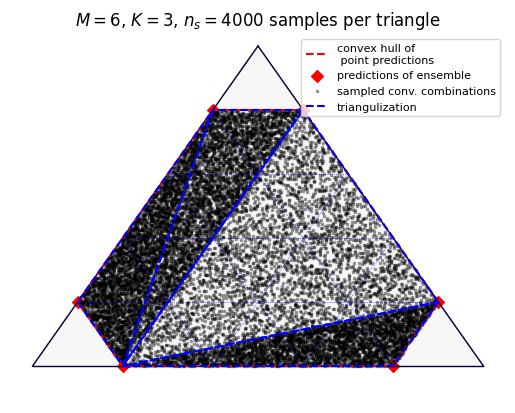

In [122]:

preds_vertices = get_vertex_pairs_hull(preds_array)


# PLOT 
scale = 1

fig, tax = ternary.figure(scale=scale)
tax.boundary(linewidth=1.0)

# tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# scatter predictors
tax.plot(preds_vertices, color = 'red', linestyle='--', label='convex hull of \n point predictions')
tax.plot(preds_vertices[[0, len(preds_vertices) -1]], color='red', linestyle='--')
tax.scatter(predicts, color='red', marker='D', label='predictions of ensemble')
tax.scatter(preds_samples, marker='s', color='black', s=1.5, alpha=0.3, label='sampled conv. combinations')

for j in range(simplices.shape[0]):
    if j == 0:
        tax.plot(simplices[j], color='blue', linestyle='--', label='triangulization')
    else:
        tax.plot(simplices[j], color='blue', linestyle='--')
    tax.plot(np.vstack([simplices[j][-1], simplices[j][0]]), color='blue', linestyle='--')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.title('$M=6$, $K=3$, $n_s=4000$ samples per triangle')
plt.legend(fontsize=8)

In [123]:
def calculate_areas(simplices: np.ndarray):

    areas = []
    for j in range(simplices.shape[0]):
        (x_1, y_1), (x_2, y_2), (x_3, y_3) = simplices[j][0,:], simplices[j][1,:], simplices[j, 2]
        area = 0.5 * abs(x_1*(y_2-y_3) + x_2*(y_3-y_1) + x_3*(y_1-y_2))
        areas.append(area)

    return areas 



def sample_equally_from_delaunay_triangles(predict_points: np.ndarray, n_samples: int = 1000):
    
    # project to 2 D
    proj_points = project_points2D(predict_points)

    # delaunay triangulization
    tri = Delaunay(proj_points)

    simplices = proj_points[tri.simplices]
    areas = calculate_areas(simplices)
    total_area = sum(areas)

    samples_per_area = [int((areas[j]/total_area)*n_samples) for j in range(len(areas))]

    simplices_3d = []
    list_samples = []
    for j in range(simplices.shape[0]):
        points_3d = planes_to_coordinates3D(simplices[j])
        samples = sample_predictions_uniform_simplex(points_3d, size=samples_per_area[j])
        simplex_3d = planes_to_coordinates3D(simplices[j])
        list_samples.append(samples)
        simplices_3d.append(simplex_3d)

    out_samples = np.concatenate(list_samples, axis=0)
    simplices_3d = np.stack(simplices_3d, axis=0)

    

    return out_samples, simplices_3d

In [124]:
preds_samples, simplices = sample_equally_from_delaunay_triangles(predicts_array, n_samples=10000)


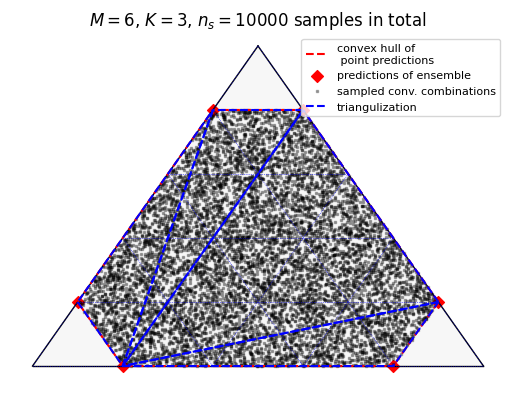

In [125]:
preds_vertices = get_vertex_pairs_hull(preds_array)


# PLOT 
scale = 1

fig, tax = ternary.figure(scale=scale)
tax.boundary(linewidth=1.0)

# tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# scatter predictors
tax.plot(preds_vertices, color = 'red', linestyle='--', label='convex hull of \n point predictions')
tax.plot(preds_vertices[[0, len(preds_vertices) -1]], color='red', linestyle='--')
tax.scatter(predicts, color='red', marker='D', label='predictions of ensemble')
tax.scatter(preds_samples, marker='s', color='black', s=1.5, alpha=0.3, label='sampled conv. combinations')

for j in range(simplices.shape[0]):
    if j == 0:
        tax.plot(simplices[j], color='blue', linestyle='--', label='triangulization')
    else:
        tax.plot(simplices[j], color='blue', linestyle='--')
    tax.plot(np.vstack([simplices[j][-1], simplices[j][0]]), color='blue', linestyle='--')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.title('$M=6$, $K=3$, $n_s=10000$ samples in total')
plt.legend(fontsize=8)

In [126]:
predicts = [(0.2, 0.8, 0.0), (0.8, .2, 0.0), (0.0, .8, .2), (0.0, .2, .8), (.8, 0, .2), (.2, 0, .8)]

ValueError: too many values to unpack (expected 2)

[0.20784609690826528,
 0.05196152422706632,
 0.05196152422706632,
 0.06928203230275512]